In [1]:
import os
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy
from astropy.io import fits

import pymangle

In [103]:
# All data from: https://data.sdss.org/sas/dr12/boss/lss/
# More info: https://sites.google.com/view/learningouruniverse/boss-analysis?authuser=0

fname = 'data/galaxy_DR12v5_CMASSLOWZTOT_North.fits'
with fits.open(fname) as hdul:
    x = hdul[1].data['RA']
    y = hdul[1].data['DEC']
    z = hdul[1].data['Z']
    
rdz = np.array([x,y,z]).T

In [104]:
mask = (rdz[:,-1]>0.4) & (rdz[:,-1]<0.7)
rdz = rdz[mask]

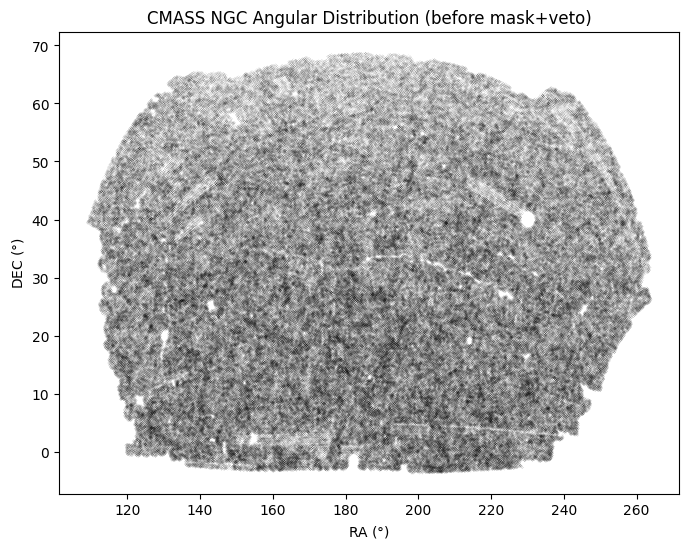

In [105]:
f,ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(*(rdz[:,:-1].T),'k.', alpha=1, markersize=0.05)
ax.set_xlabel(r'RA $(\degree)$')
ax.set_ylabel(r'DEC $(\degree)$')
ax.set_title('CMASS NGC Angular Distribution (before mask+veto)')

f.savefig('images/cmass_beforemask.jpg', dpi=400, bbox_inches='tight')

In [106]:
# from https://github.com/changhoonhahn/simbig/blob/main/src/simbig/forwardmodel.py

def BOSS_angular(ra, dec): 
    ''' Given RA and Dec, check whether the galaxies are within the angular
    mask of BOSS
    '''
    f_poly = os.path.join('data', 'mask_DR12v5_CMASSLOWZ_North.ply')
    mask = pymangle.Mangle(f_poly)
    
    w = mask.weight(ra, dec)
    inpoly = (w > 0.) 
    return inpoly 

def BOSS_veto(ra, dec): 
    ''' given RA and Dec, find the objects that fall within one of the veto 
    masks of BOSS. At the moment it checks through the veto masks one by one.  
    '''
    in_veto = np.zeros(len(ra)).astype(bool) 
    fvetos = [
            'badfield_mask_postprocess_pixs8.ply', 
            'badfield_mask_unphot_seeing_extinction_pixs8_dr12.ply',
            'allsky_bright_star_mask_pix.ply',
            'bright_object_mask_rykoff_pix.ply', 
            'centerpost_mask_dr12.ply', 
            'collision_priority_mask_dr12.ply']

    veto_dir = 'data'
    for fveto in fvetos: 
        print(fveto)
        veto = pymangle.Mangle(os.path.join(veto_dir, fveto))
        w_veto = veto.weight(ra, dec)
        in_veto = in_veto | (w_veto > 0.)
    return in_veto

In [107]:
inpoly = BOSS_angular(*rdz[:,:-1].T)
inveto = BOSS_veto(*rdz[:,:-1].T)

badfield_mask_postprocess_pixs8.ply
badfield_mask_unphot_seeing_extinction_pixs8_dr12.ply
allsky_bright_star_mask_pix.ply
bright_object_mask_rykoff_pix.ply
centerpost_mask_dr12.ply
collision_priority_mask_dr12.ply


In [108]:
mask = inpoly & (~inveto)
rdz = rdz[mask]

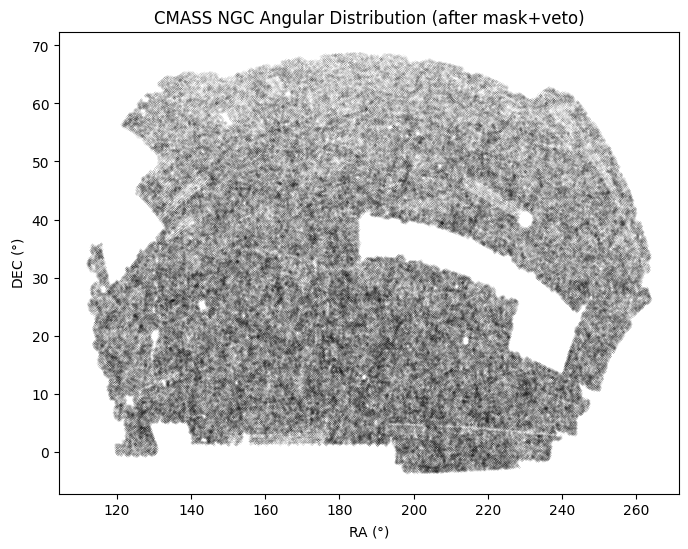

In [109]:
f,ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(*(rdz[:,:-1].T),'k.', alpha=1, markersize=0.05)
ax.set_xlabel(r'RA $(\degree)$')
ax.set_ylabel(r'DEC $(\degree)$')
ax.set_title('CMASS NGC Angular Distribution (after mask+veto)')

f.savefig('images/cmass_aftermask.jpg', dpi=400, bbox_inches='tight')

# Plot comoving

In [110]:
import nbodykit.lab as NBlab
from nbodykit import cosmology

cosmo = cosmology.Cosmology()

In [118]:
DECcen = 5
mask = np.abs(rdz[:,1]-DECcen) < 1

In [119]:
pos = NBlab.transform.SkyToCartesian(*rdz[mask,:].T, cosmo)
cxyzS = pos.compute()

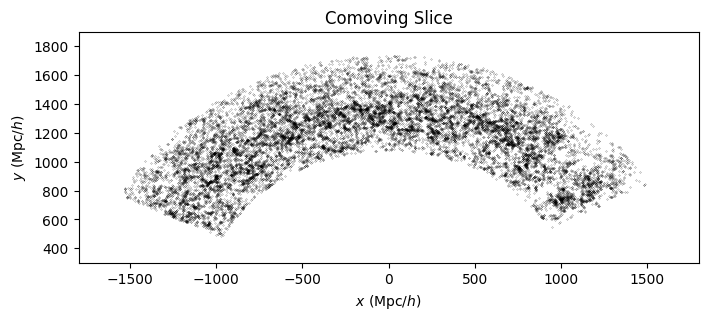

In [120]:
f, ax = plt.subplots(1,1, figsize=(8,3))
ax.plot(cxyzS[:,1], -cxyzS[:,0], 'k.', alpha=1, markersize=0.3)
ax.set_xlim(-1800,1800)
ax.set_ylim(300,1900)
ax.set_xlabel(r'$x\ (\mathrm{Mpc}/h)$')
ax.set_ylabel(r'$y\ (\mathrm{Mpc}/h)$')
ax.set_title('Comoving Slice')

f.savefig('images/cmass_comoving.jpg', dpi=400, bbox_inches='tight')

# Mock

In [130]:
pos = NBlab.transform.SkyToCartesian(*rdz.T, cosmo)
cxyz = pos.compute()

In [131]:
lims = []
for t in cxyz.T:
    lims.append((t.min(), t.max()))

In [132]:
cmask = (cy>-500) & (cy<500)
cmask *= (-cx>1200) & (-cx<1400)
cmask *= (cz>100) & (cz<140)
nbar = np.sum(cmask)/(1000*200*40) # gals/(Mpc/h)^3

vol = 1
for l in lims:
    vol *= np.diff(l)
N = int(vol[0]*nbar)

In [133]:
mxyz = np.zeros((N,3))
for i in range(3):
    mxyz[:,i] = np.random.uniform(*lims[i], size=N)

In [146]:
pos = NBlab.transform.CartesianToSky(mxyz, cosmo)
mrdz = pos.compute().T

In [147]:
mask = (mrdz[:,-1]>0.4) & (mrdz[:,-1]<0.7)
mrdz = mrdz[mask]

In [149]:
inpoly = BOSS_angular(*mrdz[:,:-1].T)
inveto = BOSS_veto(*mrdz[:,:-1].T)

badfield_mask_postprocess_pixs8.ply
badfield_mask_unphot_seeing_extinction_pixs8_dr12.ply
allsky_bright_star_mask_pix.ply
bright_object_mask_rykoff_pix.ply
centerpost_mask_dr12.ply
collision_priority_mask_dr12.ply


In [150]:
mask = inpoly & (~inveto)
mrdz = mrdz[mask]

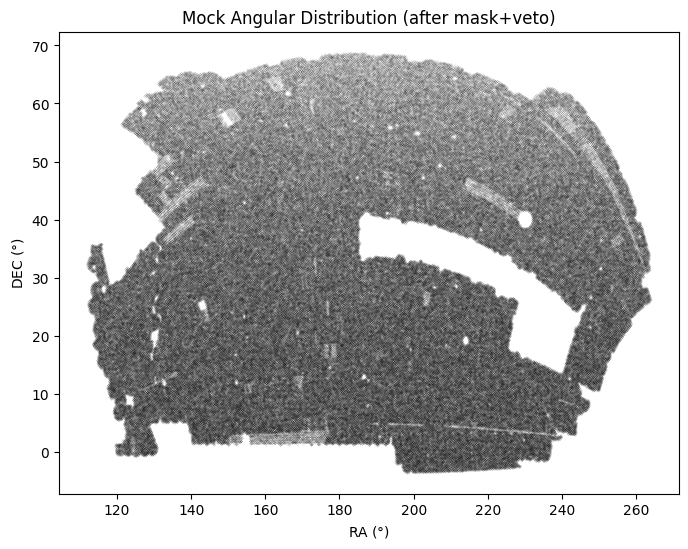

In [151]:
f,ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(*(mrdz[:,:-1].T),'k.', alpha=1, markersize=0.05)
ax.set_xlabel(r'RA $(\degree)$')
ax.set_ylabel(r'DEC $(\degree)$')
ax.set_title('Mock Angular Distribution (after mask+veto)')

f.savefig('images/mock_aftermask.jpg', dpi=400, bbox_inches='tight')

In [152]:
DECcen = 5
mask = np.abs(mrdz[:,1]-DECcen) < 1

In [153]:
pos = NBlab.transform.SkyToCartesian(*mrdz[mask,:].T, cosmo)
mxyzS = pos.compute()

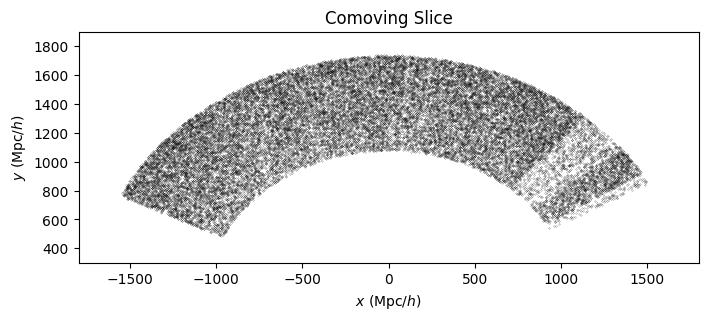

In [154]:
f, ax = plt.subplots(1,1, figsize=(8,3))
ax.plot(mxyzS[:,1], -mxyzS[:,0], 'k.', alpha=1, markersize=0.3)
ax.set_xlim(-1800,1800)
ax.set_ylim(300,1900)
ax.set_xlabel(r'$x\ (\mathrm{Mpc}/h)$')
ax.set_ylabel(r'$y\ (\mathrm{Mpc}/h)$')
ax.set_title('Comoving Slice')

f.savefig('images/mock_comoving.jpg', dpi=400, bbox_inches='tight')

# Calculate power spectra

nbodykit: https://nbodykit.readthedocs.io/en/latest/cookbook/boss-dr12-data.html

simbig: https://github.com/changhoonhahn/simbig/blob/52e381d4fb82417dc9dbac0188b6d520deffc429/src/simbig/obs.py#L17